# Strain mapping example
This is an example notebook on how to use the software package for the single Bragg edge fitting, for the analysis  of strain and texture variations.
The dataset is composed of multiple laser powder bed fusion cubical samples with increasing strain towards the surfaces along the building direction (horizontal in the images). Some samples are treated by laser shock peening, in different modalities, a process that serves to decrease the strain. 
The data is pre-processed and reduced to a transmission 3D-array with dimension (**pixel_x, pixel_y, lambda**).

# Importing python modules and functions

In [82]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
%matplotlib inline
import h5py
import sys
import glob
from ipywidgets import widgets
from IPython.core.display import HTML
from IPython.display import display

import ipywe.fileselector
from NeuNorm.normalization import Normalization
from neutronbraggedge.experiment_handler import TOF, Experiment

from ToFImaging import edgefitting_2D
from ToFImaging import edgefitting_1D
from ToFImaging import reduction_tools

# Loading Data and time spectra

## Load tif projections 

In [6]:
# debugging only
start_dir = "/Users/j35/IPTS/SNAP/Si_normalized/"

In [48]:
def load_tif(input_folder):
    global T
    list_tif = glob.glob(input_folder + "/*.tif")
    list_tif.sort()
    o_norm = Normalization()
    o_norm.load(file=list_tif, notebook=True)
    T = np.array(o_norm.data['sample']['data'])

fsel_ui = ipywe.fileselector.FileSelectorPanel(instruction='Select data folder ...',
                                               start_dir=start_dir,
                                               type='directory',
                                               next=load_tif,
                                               multiple=False)
fsel_ui.show()                                               

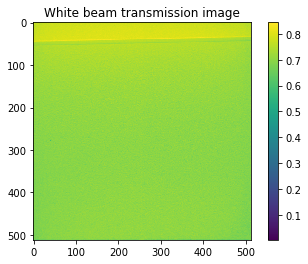

In [49]:
# x, y, lambda
T = T.transpose(1, 2, 0)

# plotting white beam transmission image
plt.imshow(np.nanmean(T,axis=2))
plt.title('White beam transmission image'), plt.colorbar()
plt.show()
plt.close()

## Load time spectra and define instrument

In [50]:
box2 = widgets.HBox([widgets.Label("dSD (m)",
                                   layout=widgets.Layout(width="150px")),
                     widgets.Text(str(16.08),
                                   layout=widgets.Layout(width='30%'))])

box3 = widgets.HBox([widgets.Label("detector offset (microns)",
                                   layout=widgets.Layout(width="150px")),
                     widgets.Text(str(3700),
                                  layout=widgets.Layout(width='30%'))])

vertical_box = widgets.VBox([box2, box3])
display(vertical_box)

dsd = box2.children[1]
doff = box3.children[1]

In [52]:
ts_ui = ipywe.fileselector.FileSelectorPanel(instruction='Select time spectra file ...',
                                             default_filter='ASCII',
                                             filters={'ASCII': ['*.txt']},
                                             start_dir=fsel_ui.selected)
ts_ui.show()

In [53]:
tof_handler = TOF(filename=ts_ui.selected)
exp_handler = Experiment(tof=tof_handler.tof_array,
                         distance_source_detector_m=np.float(dsd.value),
                         detector_offset_micros=np.float(doff.value))
lambda_array = exp_handler.lambda_array * 1e10 # to be in Angstroms

# Prepare fitting mask 

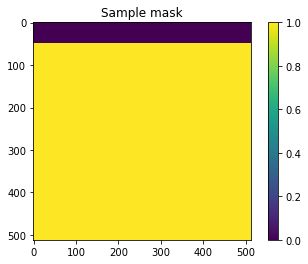

In [70]:
#preparing fitting mask
mask = np.zeros(np.shape(np.nanmean(T,axis=2)))
mask[50:,:] = 1
# mask[mask<0.7]=0
# mask[mask>0]=1
plt.imshow(mask)
plt.title('Sample mask')
plt.colorbar()
plt.show()
plt.close()

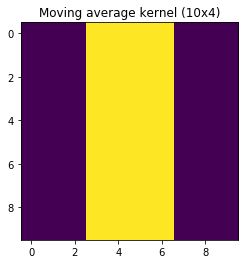

100%|██████████| 1474/1474 [01:38<00:00, 14.95it/s]


In [71]:
# moving average with custom kernel to increase neutron statistics
custom_kernel = np.zeros((10,10))
custom_kernel[:,3:7] = 1
plt.imshow(custom_kernel)
plt.title('Moving average kernel (10x4)'),
plt.show()
plt.close()

T_mavg = reduction_tools.moving_average_2D(T, 
                                           custom_kernel=custom_kernel)

# Data fitting
Data is now ready for fitting. We fit both using Gaussian method and Advanced method. In both case we test first on a single pixel by setting the debug_idx parameter, and we use the fit results as initial guess for the full image fitting to increase performance (both speed and quality).

## Preview of signal (counts vs lambda) 

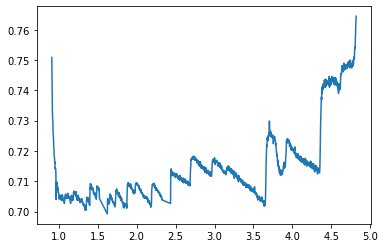

In [72]:
# plt.figure(0)
integrated_signal = np.nanmean(np.nanmean(T,axis=0), axis=0)
plt.plot(lambda_array, integrated_signal)


# Fitting of integrated signal

Edge position =  4.360234685419617
Edge height =  0.016479482134878452
Edge width =  0.008630140257503369
idx_low =  140 idx_high =  146


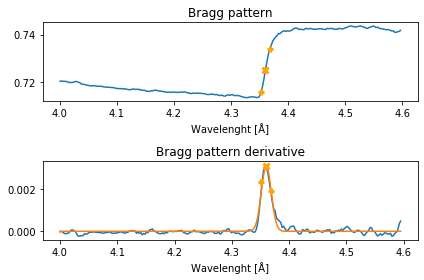

In [92]:
fit = edgefitting_1D.GaussianBraggEdgeFitting(integrated_signal, 
                                             lambda_array, 
                                              spectrum_range=[4.0, 4.6],
                                             bool_log=False,
                                             est_pos=edge_pos,
                                             pos_BC=lrange,
                                             bool_smooth=True, 
                                             smooth_w=5,
                                              bool_print=True,
                                             smooth_n=1)


## Gaussian fitting

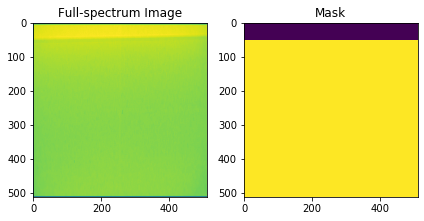

Edge position =  4.353134210451323
Edge height =  0.06615395890556723
Edge width =  0.006726031796615221
idx_low =  137 idx_high =  143


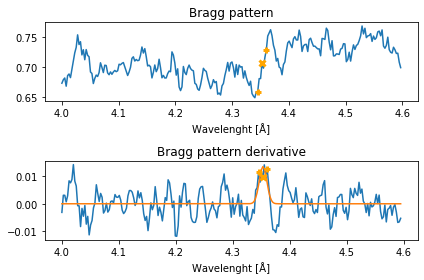

In [93]:
# here we test on a single pixel
lrange = [4.0, 4.6]
edge_pos = 4.4
pixel = [300,300]
fit = edgefitting_2D.GaussianBraggEdgeFitting_2D(T_mavg, 
                                                 lambda_array, 
                                                 lrange, 
                                                 mask=mask,
                                                 bool_log=False,
                                                 est_pos=edge_pos,
                                                 pos_BC=lrange,
                                                 bool_smooth=True, 
                                                 smooth_w=5, 
                                                 smooth_n=1, 
                                                 debug_idx=pixel)

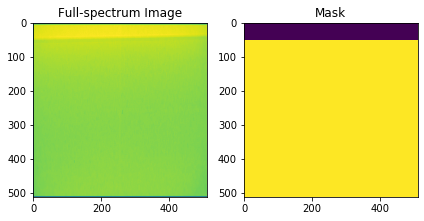

100%|██████████| 512/512 [12:12<00:00,  1.43s/it]


--- 732.1053302288055 seconds ---


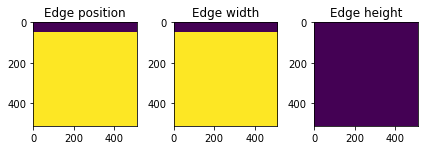

In [75]:
# lrange = [3.5, 4.5]
# edge_pos = 4.14
est_h = 0.7
est_wid = 0.01
pos_BC=[4.1,4.2]
wid_BC=[0.0,0.02]
fit_G = edgefitting_2D.GaussianBraggEdgeFitting_2D(T_mavg, 
                                                   lambda_array, 
                                                   lrange, 
                                                   mask=mask,
                                                   bool_log=True,
                                                   est_pos=edge_pos,
                                                   est_wid=est_wid,
                                                   est_h=est_h, 
                                                   pos_BC=pos_BC,
                                                   wid_BC=wid_BC,
                                                   bool_smooth=True,
                                                   smooth_w=5,
                                                   smooth_n=1,
                                                   bool_print=1)
scipy.io.savemat('fit_gauss_111.mat',fit_G)

## Advanced Fitting

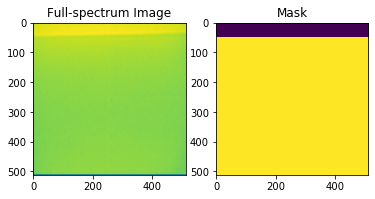

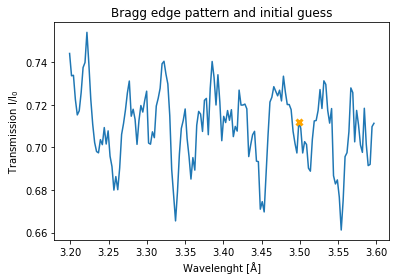

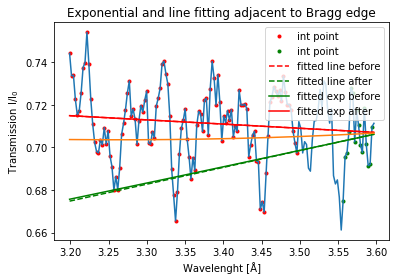

[[Model]]
    Model(BraggEdgeExponential)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 22
    # data points      = 159
    # variables        = 7
    chi-square         = 0.04063105
    reduced chi-square = 2.6731e-04
    Akaike info crit   = -1301.26819
    Bayesian info crit = -1279.78586
[[Variables]]
    t0:     3.19895624 +/- 1368.66174 (42784.63%) (init = 3.198955)
    alpha:  1.15998470 +/- 6888.00218 (593801.12%) (init = 1.195104)
    sigma:  0.66446885 +/- 21.5695965 (3246.14%) (init = 0.8022125)
    a1:    -4.15996820 +/- 12642.5460 (303909.68%) (init = -3.563783)
    a2:     0.98454560 +/- 2018.69820 (205038.57%) (init = 0.8331819)
    a5:    -134.387808 +/- 6396.41056 (4759.67%) (init = -151.4637)
    a6:     43.1948073 +/- 592.780179 (1372.34%) (init = 48.51233)
[[Correlations]] (unreported correlations are < 0.100)
    C(a1, a2)       = -1.000
    C(alpha, a1)    = -1.000
    C(alpha, a2)    =  1.000
    C(t0, a2)       =  1.000
    C

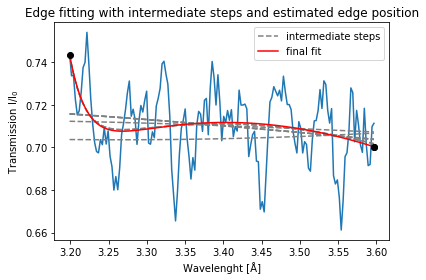

In [76]:
# lrange = [3.0, 4.5]
# edge_pos = 4.14
fit = edgefitting_2D.AdvancedBraggEdgeFitting_2D(T_mavg, 
                                                 lambda_array,
                                                 lrange,
                                                 mask=mask,
                                                 est_pos=edge_pos,
                                                 bool_smooth=True,
                                                 smooth_w=5,
                                                 smooth_n=1, 
                                                 debug_idx=pixel)

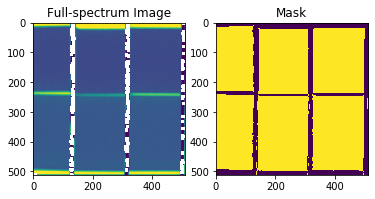

  0%|                                                  | 0/512 [00:00<?, ?it/s]

Unexpected error at : 0 310
Unexpected error at : 0 322


  0%|                                          | 1/512 [00:01<09:54,  1.16s/it]

Unexpected error at : 1 310
Unexpected error at : 1 322


  0%|▏                                         | 2/512 [00:02<09:58,  1.17s/it]C:\Users\busi_m\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\_lsq\common.py:502: RuntimeWarning: invalid value encountered in less
  mask = (g < 0) & np.isfinite(ub)
C:\Users\busi_m\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\_lsq\common.py:506: RuntimeWarning: invalid value encountered in greater
  mask = (g > 0) & np.isfinite(lb)


Unexpected error at : 2 126
Unexpected error at : 2 310
Unexpected error at : 2 322
Unexpected error at : 2 507


  1%|▏                                         | 3/512 [00:03<08:56,  1.05s/it]

Unexpected error at : 3 126
Unexpected error at : 3 310
Unexpected error at : 3 322
Unexpected error at : 3 507


  1%|▎                                         | 4/512 [00:03<07:16,  1.16it/s]

Unexpected error at : 4 126
Unexpected error at : 4 141
Unexpected error at : 4 310
Unexpected error at : 4 507


  1%|▍                                         | 5/512 [00:03<06:01,  1.40it/s]

Unexpected error at : 5 141
Unexpected error at : 5 507


  1%|▍                                         | 6/512 [00:04<04:48,  1.76it/s]

Unexpected error at : 6 141
Unexpected error at : 6 497
Unexpected error at : 6 507


  1%|▌                                         | 7/512 [00:04<04:07,  2.04it/s]

Unexpected error at : 7 141
Unexpected error at : 7 507


  2%|▋                                         | 8/512 [00:04<03:36,  2.33it/s]

Unexpected error at : 8 507


  2%|▉                                        | 11/512 [00:05<02:13,  3.77it/s]

Unexpected error at : 11 125
Unexpected error at : 11 507


  3%|█                                        | 13/512 [00:05<01:49,  4.56it/s]

Unexpected error at : 13 507


  3%|█▏                                       | 15/512 [00:08<07:00,  1.18it/s]

Unexpected error at : 15 310


  3%|█▎                                       | 17/512 [00:29<49:35,  6.01s/it]

Unexpected error at : 17 310
Unexpected error at : 17 497


  4%|█▍                                     | 19/512 [00:56<1:21:10,  9.88s/it]

Unexpected error at : 19 507


  4%|█▌                                     | 21/512 [01:28<1:49:28, 13.38s/it]

Unexpected error at : 21 507


  4%|█▋                                     | 22/512 [02:00<2:34:35, 18.93s/it]

Unexpected error at : 22 310


  4%|█▊                                     | 23/512 [02:30<3:02:30, 22.39s/it]

Unexpected error at : 23 310
Unexpected error at : 23 507


  8%|███▎                                   | 43/512 [23:06<7:11:12, 55.16s/it]

Unexpected error at : 43 481


  9%|███▎                                   | 44/512 [23:57<7:02:13, 54.13s/it]

Unexpected error at : 44 508


  9%|███▌                                   | 46/512 [25:47<7:03:09, 54.48s/it]

Unexpected error at : 46 508


 10%|███▉                                   | 52/512 [31:23<7:08:53, 55.94s/it]

Unexpected error at : 52 508


 10%|████                                   | 53/512 [32:20<7:09:01, 56.08s/it]

Unexpected error at : 53 508


 11%|████▎                                  | 57/512 [36:11<7:18:43, 57.85s/it]

Unexpected error at : 57 508


 11%|████▍                                  | 58/512 [37:36<8:17:53, 65.80s/it]

Unexpected error at : 58 508


 13%|████▉                                  | 65/512 [44:18<6:59:41, 56.33s/it]

Unexpected error at : 65 508


 14%|█████▎                                 | 70/512 [50:22<8:49:05, 71.82s/it]

Unexpected error at : 70 188


 15%|█████▊                                 | 76/512 [57:34<8:57:23, 73.95s/it]

Unexpected error at : 76 471
Unexpected error at : 76 508


 15%|█████▋                               | 78/512 [1:00:13<9:23:57, 77.97s/it]

Unexpected error at : 78 508


 16%|█████▊                               | 80/512 [1:02:39<9:01:58, 75.27s/it]

Unexpected error at : 80 508


 16%|█████▊                               | 81/512 [1:03:39<8:27:39, 70.67s/it]

Unexpected error at : 81 508


 16%|█████▉                               | 82/512 [1:05:10<9:10:52, 76.87s/it]

Unexpected error at : 82 508


 16%|█████▉                               | 83/512 [1:06:13<8:38:58, 72.58s/it]

Unexpected error at : 83 508


 20%|███████                             | 101/512 [1:28:41<8:38:04, 75.63s/it]

Unexpected error at : 101 139


 20%|███████▏                            | 102/512 [1:29:39<8:00:38, 70.34s/it]

Unexpected error at : 102 139


 20%|███████▏                            | 103/512 [1:31:00<8:21:43, 73.60s/it]

Unexpected error at : 103 139


 20%|███████▎                            | 104/512 [1:32:27<8:48:10, 77.67s/it]

Unexpected error at : 104 139


 21%|███████▍                            | 105/512 [1:33:41<8:38:44, 76.47s/it]

Unexpected error at : 105 139


 21%|███████▍                            | 106/512 [1:35:07<8:57:34, 79.44s/it]

Unexpected error at : 106 139


 21%|███████▌                            | 107/512 [1:36:14<8:31:07, 75.72s/it]

Unexpected error at : 107 139


 21%|███████▌                            | 108/512 [1:37:40<8:49:20, 78.62s/it]

Unexpected error at : 108 139


 21%|███████▋                            | 109/512 [1:38:56<8:42:45, 77.83s/it]

Unexpected error at : 109 139
Unexpected error at : 109 508


 21%|███████▋                            | 110/512 [1:40:14<8:41:59, 77.91s/it]

Unexpected error at : 110 508


 22%|███████▊                            | 111/512 [1:41:40<8:58:02, 80.50s/it]

Unexpected error at : 111 139
Unexpected error at : 111 508


 22%|███████▉                            | 112/512 [1:43:01<8:57:30, 80.63s/it]

Unexpected error at : 112 508


 22%|███████▉                            | 113/512 [1:44:07<8:27:10, 76.27s/it]

Unexpected error at : 113 508


 22%|████████                            | 114/512 [1:45:28<8:34:39, 77.59s/it]

Unexpected error at : 114 508


 23%|████████▏                           | 117/512 [1:49:13<8:22:54, 76.39s/it]

Unexpected error at : 117 139
Unexpected error at : 117 508


 23%|████████▎                           | 118/512 [1:50:29<8:19:51, 76.12s/it]

Unexpected error at : 118 508


 23%|████████▎                           | 119/512 [1:52:01<8:49:33, 80.85s/it]

Unexpected error at : 119 508


 24%|████████▌                           | 122/512 [1:55:36<8:05:26, 74.68s/it]

Unexpected error at : 122 508


 25%|████████▊                           | 126/512 [1:59:41<6:57:48, 64.94s/it]

Unexpected error at : 126 196


 25%|████████▉                           | 127/512 [2:00:39<6:44:35, 63.05s/it]

Unexpected error at : 127 508


 25%|█████████                           | 128/512 [2:01:37<6:32:17, 61.30s/it]

Unexpected error at : 128 508


 25%|█████████                           | 129/512 [2:02:35<6:24:48, 60.28s/it]

Unexpected error at : 129 508


 26%|█████████▍                          | 134/512 [2:08:56<7:41:32, 73.26s/it]

Unexpected error at : 134 508


 28%|█████████▉                          | 142/512 [2:18:46<7:37:50, 74.24s/it]

Unexpected error at : 142 266


 32%|███████████▌                        | 165/512 [2:47:16<7:39:50, 79.51s/it]

Unexpected error at : 165 140


 34%|████████████▎                       | 175/512 [2:59:53<6:54:48, 73.85s/it]

Unexpected error at : 175 507


 35%|████████████▋                       | 181/512 [3:07:40<6:48:39, 74.08s/it]

Unexpected error at : 181 507


 36%|████████████▊                       | 182/512 [3:09:05<7:04:35, 77.20s/it]

Unexpected error at : 182 507


 36%|████████████▉                       | 184/512 [3:11:35<6:59:24, 76.72s/it]

Unexpected error at : 184 507


 37%|█████████████▍                      | 191/512 [3:20:39<7:31:08, 84.33s/it]

Unexpected error at : 191 140
Unexpected error at : 191 284


 38%|█████████████▋                      | 195/512 [3:25:29<6:38:40, 75.46s/it]

Unexpected error at : 195 507


 40%|██████████████▎                     | 204/512 [3:35:41<5:18:20, 62.01s/it]

Unexpected error at : 204 507


 40%|██████████████▌                     | 207/512 [3:38:44<5:08:04, 60.61s/it]

Unexpected error at : 207 507


 42%|███████████████                     | 214/512 [3:45:31<4:46:12, 57.62s/it]

Unexpected error at : 214 507


 42%|███████████████▏                    | 216/512 [3:47:33<4:50:14, 58.83s/it]

Unexpected error at : 216 507


 42%|███████████████▎                    | 217/512 [3:48:29<4:45:12, 58.01s/it]

Unexpected error at : 217 507


 43%|███████████████▎                    | 218/512 [3:49:27<4:44:39, 58.09s/it]

Unexpected error at : 218 507


 43%|███████████████▍                    | 219/512 [3:50:35<4:58:00, 61.03s/it]

Unexpected error at : 219 507


 43%|███████████████▌                    | 221/512 [3:52:33<4:50:51, 59.97s/it]

Unexpected error at : 221 507


 44%|███████████████▋                    | 223/512 [3:54:45<5:01:59, 62.70s/it]

Unexpected error at : 223 507


 44%|███████████████▊                    | 224/512 [3:55:44<4:55:46, 61.62s/it]

Unexpected error at : 224 507


 44%|███████████████▊                    | 225/512 [3:56:42<4:49:08, 60.45s/it]

Unexpected error at : 225 507


 44%|███████████████▉                    | 226/512 [3:57:53<5:03:38, 63.70s/it]

Unexpected error at : 226 507


 44%|███████████████▉                    | 227/512 [3:58:54<4:59:09, 62.98s/it]

Unexpected error at : 227 507


 45%|████████████████▏                   | 231/512 [4:02:57<4:46:40, 61.21s/it]

Unexpected error at : 231 507


 46%|████████████████▍                   | 234/512 [4:05:13<3:51:08, 49.89s/it]

Unexpected error at : 234 507


 46%|████████████████▋                   | 238/512 [4:08:09<3:24:21, 44.75s/it]

Unexpected error at : 238 507


 47%|████████████████▉                   | 240/512 [4:09:00<2:39:49, 35.25s/it]

Unexpected error at : 240 507


 47%|█████████████████                   | 242/512 [4:09:38<1:59:21, 26.52s/it]

Unexpected error at : 242 139


 47%|█████████████████                   | 243/512 [4:09:43<1:29:32, 19.97s/it]

Unexpected error at : 243 139


 48%|█████████████████▎                  | 246/512 [4:10:28<1:15:48, 17.10s/it]

Unexpected error at : 246 144


 51%|██████████████████▏                 | 259/512 [4:23:15<4:20:23, 61.75s/it]

Unexpected error at : 259 506


 53%|██████████████████▉                 | 270/512 [4:34:20<4:01:33, 59.89s/it]

Unexpected error at : 270 138
Unexpected error at : 270 506


 53%|███████████████████▏                | 273/512 [4:37:23<3:59:15, 60.07s/it]

Unexpected error at : 273 138


 54%|███████████████████▎                | 275/512 [4:39:19<3:53:15, 59.05s/it]

Unexpected error at : 275 506


 54%|███████████████████▍                | 276/512 [4:40:19<3:53:05, 59.26s/it]

Unexpected error at : 276 506


 55%|███████████████████▊                | 281/512 [4:45:19<3:51:37, 60.16s/it]

Unexpected error at : 281 138
Unexpected error at : 281 506


 55%|███████████████████▊                | 282/512 [4:46:20<3:51:37, 60.42s/it]

Unexpected error at : 282 138


 55%|███████████████████▉                | 283/512 [4:47:17<3:47:25, 59.59s/it]

Unexpected error at : 283 138
Unexpected error at : 283 143
Unexpected error at : 283 506


 55%|███████████████████▉                | 284/512 [4:48:15<3:43:53, 58.92s/it]

Unexpected error at : 284 138
Unexpected error at : 284 142


 56%|████████████████████                | 285/512 [4:49:12<3:40:47, 58.36s/it]

Unexpected error at : 285 142
Unexpected error at : 285 143


 56%|████████████████████                | 286/512 [4:50:11<3:40:44, 58.60s/it]

Unexpected error at : 286 138


 56%|████████████████████▏               | 287/512 [4:51:09<3:39:22, 58.50s/it]

Unexpected error at : 287 138
Unexpected error at : 287 506


 56%|████████████████████▎               | 288/512 [4:52:08<3:38:30, 58.53s/it]

Unexpected error at : 288 138
Unexpected error at : 288 142
Unexpected error at : 288 143
Unexpected error at : 288 506


 56%|████████████████████▎               | 289/512 [4:53:06<3:36:55, 58.37s/it]

Unexpected error at : 289 138
Unexpected error at : 289 142
Unexpected error at : 289 143
Unexpected error at : 289 155
Unexpected error at : 289 506


 57%|████████████████████▍               | 290/512 [4:54:03<3:34:25, 57.95s/it]

Unexpected error at : 290 142
Unexpected error at : 290 143
Unexpected error at : 290 506


 57%|████████████████████▍               | 291/512 [4:54:59<3:31:01, 57.29s/it]

Unexpected error at : 291 138
Unexpected error at : 291 142


 57%|████████████████████▌               | 292/512 [4:55:53<3:26:28, 56.31s/it]

Unexpected error at : 292 138
Unexpected error at : 292 142


 58%|████████████████████▊               | 296/512 [4:59:32<3:18:30, 55.14s/it]

Unexpected error at : 296 142


 58%|████████████████████▉               | 298/512 [5:01:21<3:15:22, 54.78s/it]

Unexpected error at : 298 505


 60%|█████████████████████▌              | 306/512 [5:08:40<3:07:33, 54.63s/it]

Unexpected error at : 306 324
Unexpected error at : 306 326


 60%|█████████████████████▌              | 307/512 [5:09:37<3:08:35, 55.20s/it]

Unexpected error at : 307 195
Unexpected error at : 307 215


 60%|█████████████████████▋              | 308/512 [5:10:33<3:08:19, 55.39s/it]

Unexpected error at : 308 214
Unexpected error at : 308 215
Unexpected error at : 308 505


 60%|█████████████████████▋              | 309/512 [5:11:27<3:06:37, 55.16s/it]

Unexpected error at : 309 505


 61%|█████████████████████▊              | 310/512 [5:12:22<3:05:19, 55.05s/it]

Unexpected error at : 310 214
Unexpected error at : 310 215


 61%|█████████████████████▊              | 311/512 [5:13:17<3:03:52, 54.89s/it]

Unexpected error at : 311 196


 61%|█████████████████████▉              | 312/512 [5:14:12<3:03:44, 55.12s/it]

Unexpected error at : 312 137


 61%|██████████████████████              | 313/512 [5:15:08<3:03:00, 55.18s/it]

Unexpected error at : 313 137
Unexpected error at : 313 214


 61%|██████████████████████              | 314/512 [5:16:01<3:00:18, 54.64s/it]

Unexpected error at : 314 137
Unexpected error at : 314 214
Unexpected error at : 314 215


 62%|██████████████████████▏             | 315/512 [5:16:54<2:58:21, 54.32s/it]

Unexpected error at : 315 214
Unexpected error at : 315 505


 62%|██████████████████████▏             | 316/512 [5:17:47<2:55:38, 53.77s/it]

Unexpected error at : 316 213


 62%|██████████████████████▎             | 317/512 [5:18:40<2:53:45, 53.46s/it]

Unexpected error at : 317 146
Unexpected error at : 317 149
Unexpected error at : 317 213


 62%|██████████████████████▎             | 318/512 [5:19:35<2:54:12, 53.88s/it]

Unexpected error at : 318 143
Unexpected error at : 318 145
Unexpected error at : 318 148


 62%|██████████████████████▍             | 319/512 [5:20:30<2:54:51, 54.36s/it]

Unexpected error at : 319 505


 62%|██████████████████████▌             | 320/512 [5:21:23<2:53:01, 54.07s/it]

Unexpected error at : 320 137
Unexpected error at : 320 144
Unexpected error at : 320 454
Unexpected error at : 320 505


 63%|██████████████████████▌             | 321/512 [5:22:16<2:50:56, 53.70s/it]

Unexpected error at : 321 137


 63%|██████████████████████▋             | 322/512 [5:23:10<2:49:57, 53.67s/it]

Unexpected error at : 322 144
Unexpected error at : 322 505


 63%|██████████████████████▋             | 323/512 [5:24:04<2:49:03, 53.67s/it]

Unexpected error at : 323 141
Unexpected error at : 323 142
Unexpected error at : 323 143
Unexpected error at : 323 294
Unexpected error at : 323 295
Unexpected error at : 323 505


 63%|██████████████████████▊             | 324/512 [5:24:59<2:49:59, 54.25s/it]

Unexpected error at : 324 141
Unexpected error at : 324 147
Unexpected error at : 324 322


 63%|██████████████████████▊             | 325/512 [5:25:54<2:49:51, 54.50s/it]

Unexpected error at : 325 137
Unexpected error at : 325 293
Unexpected error at : 325 294
Unexpected error at : 325 505


 64%|██████████████████████▉             | 326/512 [5:26:49<2:49:08, 54.56s/it]

Unexpected error at : 326 294


 64%|██████████████████████▉             | 327/512 [5:27:43<2:47:56, 54.47s/it]

Unexpected error at : 327 137
Unexpected error at : 327 294
Unexpected error at : 327 295


 64%|███████████████████████             | 328/512 [5:28:38<2:47:00, 54.46s/it]

Unexpected error at : 328 137


 64%|███████████████████████▏            | 329/512 [5:29:34<2:47:57, 55.07s/it]

Unexpected error at : 329 187


 64%|███████████████████████▏            | 330/512 [5:30:30<2:47:56, 55.37s/it]

Unexpected error at : 330 137
Unexpected error at : 330 505


 65%|███████████████████████▎            | 331/512 [5:31:26<2:47:18, 55.46s/it]

Unexpected error at : 331 137
Unexpected error at : 331 150
Unexpected error at : 331 151


 65%|███████████████████████▎            | 332/512 [5:32:21<2:45:40, 55.22s/it]

Unexpected error at : 332 137
Unexpected error at : 332 150
Unexpected error at : 332 152
Unexpected error at : 332 187


 65%|███████████████████████▍            | 333/512 [5:33:13<2:42:28, 54.46s/it]

Unexpected error at : 333 150
Unexpected error at : 333 151
Unexpected error at : 333 187
Unexpected error at : 333 188


 65%|███████████████████████▍            | 334/512 [5:34:07<2:40:33, 54.12s/it]

Unexpected error at : 334 150
Unexpected error at : 334 182
Unexpected error at : 334 187
Unexpected error at : 334 188
Unexpected error at : 334 190
Unexpected error at : 334 479


 65%|███████████████████████▌            | 335/512 [5:35:03<2:41:23, 54.71s/it]

Unexpected error at : 335 137
Unexpected error at : 335 150
Unexpected error at : 335 151
Unexpected error at : 335 188


 66%|███████████████████████▋            | 336/512 [5:35:56<2:39:24, 54.34s/it]

Unexpected error at : 336 137
Unexpected error at : 336 186
Unexpected error at : 336 321


 66%|███████████████████████▋            | 337/512 [5:36:49<2:37:00, 53.83s/it]

Unexpected error at : 337 150
Unexpected error at : 337 152
Unexpected error at : 337 183
Unexpected error at : 337 184
Unexpected error at : 337 321
Unexpected error at : 337 505


 66%|███████████████████████▊            | 339/512 [5:38:33<2:32:38, 52.94s/it]

Unexpected error at : 339 321


 66%|███████████████████████▉            | 340/512 [5:39:27<2:32:42, 53.27s/it]

Unexpected error at : 340 243


 67%|███████████████████████▉            | 341/512 [5:40:21<2:32:23, 53.47s/it]

Unexpected error at : 341 138
Unexpected error at : 341 141
Unexpected error at : 341 143
Unexpected error at : 341 241
Unexpected error at : 341 242
Unexpected error at : 341 246
Unexpected error at : 341 321


 67%|████████████████████████            | 342/512 [5:41:15<2:31:54, 53.61s/it]

Unexpected error at : 342 138
Unexpected error at : 342 142
Unexpected error at : 342 143
Unexpected error at : 342 241
Unexpected error at : 342 242
Unexpected error at : 342 243
Unexpected error at : 342 245
Unexpected error at : 342 321


 67%|████████████████████████            | 343/512 [5:42:08<2:29:59, 53.25s/it]

Unexpected error at : 343 138
Unexpected error at : 343 141
Unexpected error at : 343 142
Unexpected error at : 343 145
Unexpected error at : 343 321
Unexpected error at : 343 324


 67%|████████████████████████▏           | 344/512 [5:43:00<2:28:03, 52.88s/it]

Unexpected error at : 344 138
Unexpected error at : 344 141
Unexpected error at : 344 142
Unexpected error at : 344 143
Unexpected error at : 344 144
Unexpected error at : 344 145
Unexpected error at : 344 321
Unexpected error at : 344 324
Unexpected error at : 344 505


 67%|████████████████████████▎           | 345/512 [5:43:52<2:27:11, 52.88s/it]

Unexpected error at : 345 138
Unexpected error at : 345 141
Unexpected error at : 345 142
Unexpected error at : 345 144
Unexpected error at : 345 321


 68%|████████████████████████▎           | 346/512 [5:44:48<2:28:55, 53.83s/it]

Unexpected error at : 346 139
Unexpected error at : 346 141
Unexpected error at : 346 144
Unexpected error at : 346 205
Unexpected error at : 346 206
Unexpected error at : 346 321
Unexpected error at : 346 324
Unexpected error at : 346 402


 68%|████████████████████████▍           | 347/512 [5:45:41<2:27:04, 53.48s/it]

Unexpected error at : 347 139
Unexpected error at : 347 141
Unexpected error at : 347 143
Unexpected error at : 347 144
Unexpected error at : 347 172
Unexpected error at : 347 321
Unexpected error at : 347 505


 68%|████████████████████████▍           | 348/512 [5:46:29<2:21:29, 51.77s/it]

Unexpected error at : 348 139
Unexpected error at : 348 140
Unexpected error at : 348 141
Unexpected error at : 348 505


 68%|████████████████████████▌           | 349/512 [5:47:17<2:17:17, 50.54s/it]

Unexpected error at : 349 139
Unexpected error at : 349 140


 68%|████████████████████████▌           | 350/512 [5:48:05<2:14:57, 49.98s/it]

Unexpected error at : 350 139
Unexpected error at : 350 505


 69%|████████████████████████▋           | 351/512 [5:48:54<2:12:43, 49.46s/it]

Unexpected error at : 351 122
Unexpected error at : 351 140


 69%|████████████████████████▊           | 352/512 [5:49:43<2:12:01, 49.51s/it]

Unexpected error at : 352 127


 69%|████████████████████████▊           | 353/512 [5:50:32<2:10:34, 49.27s/it]

Unexpected error at : 353 122
Unexpected error at : 353 505


 69%|████████████████████████▉           | 354/512 [5:51:22<2:10:30, 49.56s/it]

Unexpected error at : 354 140
Unexpected error at : 354 505


 69%|████████████████████████▉           | 355/512 [5:52:12<2:09:45, 49.59s/it]

Unexpected error at : 355 140
Unexpected error at : 355 141
Unexpected error at : 355 505


 70%|█████████████████████████           | 356/512 [5:53:01<2:08:43, 49.51s/it]

Unexpected error at : 356 141
Unexpected error at : 356 143


 70%|█████████████████████████           | 357/512 [5:53:51<2:08:18, 49.67s/it]

Unexpected error at : 357 141
Unexpected error at : 357 288
Unexpected error at : 357 294
Unexpected error at : 357 505


 70%|█████████████████████████▏          | 358/512 [5:54:41<2:07:56, 49.85s/it]

Unexpected error at : 358 140
Unexpected error at : 358 141
Unexpected error at : 358 287
Unexpected error at : 358 288
Unexpected error at : 358 293
Unexpected error at : 358 294
Unexpected error at : 358 505


 70%|█████████████████████████▏          | 359/512 [5:55:30<2:06:25, 49.58s/it]

Unexpected error at : 359 151
Unexpected error at : 359 152
Unexpected error at : 359 168
Unexpected error at : 359 276
Unexpected error at : 359 293
Unexpected error at : 359 294
Unexpected error at : 359 505


 70%|█████████████████████████▎          | 360/512 [5:56:21<2:06:30, 49.94s/it]

Unexpected error at : 360 54
Unexpected error at : 360 141
Unexpected error at : 360 505


 71%|█████████████████████████▍          | 361/512 [5:57:12<2:06:15, 50.17s/it]

Unexpected error at : 361 141
Unexpected error at : 361 142
Unexpected error at : 361 143
Unexpected error at : 361 151
Unexpected error at : 361 153
Unexpected error at : 361 154


 71%|█████████████████████████▍          | 362/512 [5:58:02<2:05:37, 50.25s/it]

Unexpected error at : 362 141
Unexpected error at : 362 154


 71%|█████████████████████████▌          | 363/512 [5:58:53<2:04:50, 50.27s/it]

Unexpected error at : 363 141
Unexpected error at : 363 152
Unexpected error at : 363 153
Unexpected error at : 363 392


 71%|█████████████████████████▌          | 364/512 [5:59:43<2:04:09, 50.33s/it]

Unexpected error at : 364 151
Unexpected error at : 364 152
Unexpected error at : 364 153
Unexpected error at : 364 154


 71%|█████████████████████████▋          | 365/512 [6:00:33<2:02:43, 50.09s/it]

Unexpected error at : 365 150
Unexpected error at : 365 152
Unexpected error at : 365 153
Unexpected error at : 365 154
Unexpected error at : 365 155
Unexpected error at : 365 159


 71%|█████████████████████████▋          | 366/512 [6:01:21<2:00:29, 49.52s/it]

Unexpected error at : 366 153
Unexpected error at : 366 154
Unexpected error at : 366 322


 72%|█████████████████████████▊          | 367/512 [6:02:09<1:58:22, 48.98s/it]

Unexpected error at : 367 127
Unexpected error at : 367 151
Unexpected error at : 367 152
Unexpected error at : 367 153
Unexpected error at : 367 505


 72%|█████████████████████████▉          | 368/512 [6:02:57<1:57:22, 48.91s/it]

Unexpected error at : 368 505


 72%|█████████████████████████▉          | 369/512 [6:03:47<1:56:49, 49.02s/it]

Unexpected error at : 369 43
Unexpected error at : 369 127
Unexpected error at : 369 154
Unexpected error at : 369 505


 72%|██████████████████████████          | 370/512 [6:04:36<1:56:25, 49.19s/it]

Unexpected error at : 370 249
Unexpected error at : 370 505


 72%|██████████████████████████          | 371/512 [6:05:26<1:55:45, 49.26s/it]

Unexpected error at : 371 249
Unexpected error at : 371 250
Unexpected error at : 371 251
Unexpected error at : 371 262
Unexpected error at : 371 263


 73%|██████████████████████████▏         | 372/512 [6:06:15<1:55:03, 49.31s/it]

Unexpected error at : 372 169
Unexpected error at : 372 250
Unexpected error at : 372 505


 73%|██████████████████████████▏         | 373/512 [6:07:04<1:53:53, 49.16s/it]

Unexpected error at : 373 169
Unexpected error at : 373 263
Unexpected error at : 373 264


 73%|██████████████████████████▎         | 374/512 [6:07:52<1:52:13, 48.80s/it]

Unexpected error at : 374 220
Unexpected error at : 374 321


 73%|██████████████████████████▎         | 375/512 [6:08:41<1:51:35, 48.87s/it]

Unexpected error at : 375 169
Unexpected error at : 375 219
Unexpected error at : 375 220
Unexpected error at : 375 221


 73%|██████████████████████████▍         | 376/512 [6:09:29<1:50:28, 48.74s/it]

Unexpected error at : 376 218
Unexpected error at : 376 219
Unexpected error at : 376 220
Unexpected error at : 376 221
Unexpected error at : 376 264
Unexpected error at : 376 505


 74%|██████████████████████████▌         | 377/512 [6:10:19<1:50:31, 49.12s/it]

Unexpected error at : 377 221
Unexpected error at : 377 505


 74%|██████████████████████████▌         | 378/512 [6:11:08<1:49:46, 49.15s/it]

Unexpected error at : 378 220
Unexpected error at : 378 301


 74%|██████████████████████████▋         | 379/512 [6:11:58<1:49:14, 49.28s/it]

Unexpected error at : 379 505


 74%|██████████████████████████▋         | 380/512 [6:12:47<1:48:25, 49.29s/it]

Unexpected error at : 380 125
Unexpected error at : 380 286
Unexpected error at : 380 505


 74%|██████████████████████████▊         | 381/512 [6:13:36<1:47:03, 49.04s/it]

Unexpected error at : 381 505


 75%|██████████████████████████▊         | 382/512 [6:14:23<1:45:23, 48.64s/it]

Unexpected error at : 382 336


 75%|██████████████████████████▉         | 383/512 [6:15:10<1:42:55, 47.88s/it]

Unexpected error at : 383 124
Unexpected error at : 383 245
Unexpected error at : 383 246
Unexpected error at : 383 247
Unexpected error at : 383 335
Unexpected error at : 383 336
Unexpected error at : 383 337


 75%|███████████████████████████         | 384/512 [6:15:59<1:42:54, 48.24s/it]

Unexpected error at : 384 246
Unexpected error at : 384 247
Unexpected error at : 384 287
Unexpected error at : 384 335


 75%|███████████████████████████         | 385/512 [6:16:47<1:42:09, 48.26s/it]

Unexpected error at : 385 335
Unexpected error at : 385 336


 75%|███████████████████████████▏        | 386/512 [6:17:36<1:41:57, 48.55s/it]

Unexpected error at : 386 246


 76%|███████████████████████████▏        | 387/512 [6:18:25<1:41:10, 48.57s/it]

Unexpected error at : 387 137
Unexpected error at : 387 232
Unexpected error at : 387 244
Unexpected error at : 387 246
Unexpected error at : 387 321


 76%|███████████████████████████▎        | 388/512 [6:19:13<1:39:58, 48.37s/it]

Unexpected error at : 388 137
Unexpected error at : 388 231
Unexpected error at : 388 233
Unexpected error at : 388 245
Unexpected error at : 388 246
Unexpected error at : 388 321


 76%|███████████████████████████▎        | 389/512 [6:20:03<1:40:05, 48.82s/it]

Unexpected error at : 389 237
Unexpected error at : 389 244
Unexpected error at : 389 245
Unexpected error at : 389 246
Unexpected error at : 389 247


 76%|███████████████████████████▍        | 390/512 [6:20:52<1:39:26, 48.91s/it]

Unexpected error at : 390 231
Unexpected error at : 390 233
Unexpected error at : 390 236
Unexpected error at : 390 237
Unexpected error at : 390 244
Unexpected error at : 390 245
Unexpected error at : 390 246
Unexpected error at : 390 321


 76%|███████████████████████████▍        | 391/512 [6:21:40<1:38:12, 48.70s/it]

Unexpected error at : 391 232
Unexpected error at : 391 233
Unexpected error at : 391 237
Unexpected error at : 391 238
Unexpected error at : 391 244
Unexpected error at : 391 245
Unexpected error at : 391 246
Unexpected error at : 391 247


 77%|███████████████████████████▌        | 392/512 [6:22:29<1:37:46, 48.89s/it]

Unexpected error at : 392 136
Unexpected error at : 392 162
Unexpected error at : 392 229
Unexpected error at : 392 231
Unexpected error at : 392 233
Unexpected error at : 392 235
Unexpected error at : 392 236
Unexpected error at : 392 237
Unexpected error at : 392 238


 77%|███████████████████████████▋        | 393/512 [6:23:18<1:36:38, 48.72s/it]

Unexpected error at : 393 136
Unexpected error at : 393 161
Unexpected error at : 393 321
Unexpected error at : 393 505


 77%|███████████████████████████▋        | 394/512 [6:24:06<1:35:28, 48.54s/it]

Unexpected error at : 394 153
Unexpected error at : 394 154
Unexpected error at : 394 155
Unexpected error at : 394 229
Unexpected error at : 394 233
Unexpected error at : 394 236
Unexpected error at : 394 237
Unexpected error at : 394 344
Unexpected error at : 394 345
Unexpected error at : 394 348
Unexpected error at : 394 393
Unexpected error at : 394 481
Unexpected error at : 394 482


 77%|███████████████████████████▊        | 395/512 [6:24:54<1:34:29, 48.46s/it]

Unexpected error at : 395 153
Unexpected error at : 395 154
Unexpected error at : 395 158
Unexpected error at : 395 159
Unexpected error at : 395 160
Unexpected error at : 395 228
Unexpected error at : 395 234
Unexpected error at : 395 236
Unexpected error at : 395 275
Unexpected error at : 395 321
Unexpected error at : 395 392
Unexpected error at : 395 480
Unexpected error at : 395 481
Unexpected error at : 395 505


 77%|███████████████████████████▊        | 396/512 [6:25:42<1:33:15, 48.24s/it]

Unexpected error at : 396 148
Unexpected error at : 396 153
Unexpected error at : 396 154
Unexpected error at : 396 156
Unexpected error at : 396 157
Unexpected error at : 396 222
Unexpected error at : 396 228
Unexpected error at : 396 229
Unexpected error at : 396 233
Unexpected error at : 396 234
Unexpected error at : 396 276
Unexpected error at : 396 321
Unexpected error at : 396 392
Unexpected error at : 396 480
Unexpected error at : 396 483


 78%|███████████████████████████▉        | 397/512 [6:26:31<1:32:56, 48.49s/it]

Unexpected error at : 397 153
Unexpected error at : 397 154
Unexpected error at : 397 155
Unexpected error at : 397 227
Unexpected error at : 397 228
Unexpected error at : 397 229
Unexpected error at : 397 236
Unexpected error at : 397 275
Unexpected error at : 397 276
Unexpected error at : 397 345
Unexpected error at : 397 347
Unexpected error at : 397 348
Unexpected error at : 397 349
Unexpected error at : 397 482


 78%|███████████████████████████▉        | 398/512 [6:27:18<1:31:40, 48.25s/it]

Unexpected error at : 398 152
Unexpected error at : 398 154
Unexpected error at : 398 157
Unexpected error at : 398 158
Unexpected error at : 398 227
Unexpected error at : 398 276
Unexpected error at : 398 481
Unexpected error at : 398 505


 78%|████████████████████████████        | 399/512 [6:28:07<1:30:56, 48.29s/it]

Unexpected error at : 399 135
Unexpected error at : 399 154
Unexpected error at : 399 202
Unexpected error at : 399 276
Unexpected error at : 399 321


 78%|████████████████████████████▏       | 400/512 [6:28:57<1:31:00, 48.76s/it]

Unexpected error at : 400 135
Unexpected error at : 400 140
Unexpected error at : 400 152
Unexpected error at : 400 155
Unexpected error at : 400 321


 78%|████████████████████████████▏       | 401/512 [6:29:46<1:30:39, 49.00s/it]

Unexpected error at : 401 153
Unexpected error at : 401 207
Unexpected error at : 401 276
Unexpected error at : 401 321


 79%|████████████████████████████▎       | 402/512 [6:30:36<1:30:04, 49.13s/it]

Unexpected error at : 402 140
Unexpected error at : 402 141
Unexpected error at : 402 207
Unexpected error at : 402 505


 79%|████████████████████████████▎       | 403/512 [6:31:25<1:29:25, 49.22s/it]

Unexpected error at : 403 142
Unexpected error at : 403 234
Unexpected error at : 403 321


 79%|████████████████████████████▍       | 404/512 [6:32:14<1:28:13, 49.01s/it]

Unexpected error at : 404 234
Unexpected error at : 404 321


 79%|████████████████████████████▍       | 405/512 [6:33:03<1:27:21, 48.98s/it]

Unexpected error at : 405 140
Unexpected error at : 405 141


 79%|████████████████████████████▌       | 406/512 [6:33:51<1:26:10, 48.78s/it]

Unexpected error at : 406 142
Unexpected error at : 406 261
Unexpected error at : 406 262
Unexpected error at : 406 505


 79%|████████████████████████████▌       | 407/512 [6:34:39<1:24:59, 48.56s/it]

Unexpected error at : 407 140
Unexpected error at : 407 141
Unexpected error at : 407 142
Unexpected error at : 407 189
Unexpected error at : 407 238
Unexpected error at : 407 239
Unexpected error at : 407 262


 80%|████████████████████████████▋       | 408/512 [6:35:25<1:22:53, 47.82s/it]

Unexpected error at : 408 141
Unexpected error at : 408 239


 80%|████████████████████████████▊       | 409/512 [6:36:11<1:21:09, 47.27s/it]

Unexpected error at : 409 260


 80%|████████████████████████████▊       | 410/512 [6:36:59<1:20:30, 47.35s/it]

Unexpected error at : 410 141
Unexpected error at : 410 261
Unexpected error at : 410 262
Unexpected error at : 410 279
Unexpected error at : 410 280
Unexpected error at : 410 336
Unexpected error at : 410 337


 80%|████████████████████████████▉       | 411/512 [6:37:46<1:19:43, 47.36s/it]

Unexpected error at : 411 141
Unexpected error at : 411 187
Unexpected error at : 411 202
Unexpected error at : 411 262
Unexpected error at : 411 263
Unexpected error at : 411 337


 80%|████████████████████████████▉       | 412/512 [6:38:33<1:18:42, 47.23s/it]

Unexpected error at : 412 140
Unexpected error at : 412 141
Unexpected error at : 412 251
Unexpected error at : 412 262
Unexpected error at : 412 263
Unexpected error at : 412 276
Unexpected error at : 412 279
Unexpected error at : 412 281
Unexpected error at : 412 282


 81%|█████████████████████████████       | 413/512 [6:39:22<1:19:04, 47.92s/it]

Unexpected error at : 413 179
Unexpected error at : 413 181
Unexpected error at : 413 182
Unexpected error at : 413 183
Unexpected error at : 413 187
Unexpected error at : 413 248
Unexpected error at : 413 249
Unexpected error at : 413 250
Unexpected error at : 413 251
Unexpected error at : 413 262
Unexpected error at : 413 272
Unexpected error at : 413 279
Unexpected error at : 413 320
Unexpected error at : 413 337


 81%|█████████████████████████████       | 414/512 [6:40:12<1:19:06, 48.44s/it]

Unexpected error at : 414 140
Unexpected error at : 414 141
Unexpected error at : 414 179
Unexpected error at : 414 180
Unexpected error at : 414 186
Unexpected error at : 414 188
Unexpected error at : 414 271
Unexpected error at : 414 277
Unexpected error at : 414 281
Unexpected error at : 414 337
Unexpected error at : 414 338


 81%|█████████████████████████████▏      | 415/512 [6:41:01<1:18:39, 48.66s/it]

Unexpected error at : 415 140
Unexpected error at : 415 141
Unexpected error at : 415 178
Unexpected error at : 415 179
Unexpected error at : 415 180
Unexpected error at : 415 182
Unexpected error at : 415 184
Unexpected error at : 415 185
Unexpected error at : 415 187
Unexpected error at : 415 271
Unexpected error at : 415 277
Unexpected error at : 415 320


 81%|█████████████████████████████▎      | 416/512 [6:41:50<1:18:01, 48.77s/it]

Unexpected error at : 416 135
Unexpected error at : 416 140
Unexpected error at : 416 179
Unexpected error at : 416 180
Unexpected error at : 416 181
Unexpected error at : 416 182
Unexpected error at : 416 184
Unexpected error at : 416 187
Unexpected error at : 416 189
Unexpected error at : 416 278
Unexpected error at : 416 279
Unexpected error at : 416 280
Unexpected error at : 416 320


 81%|█████████████████████████████▎      | 417/512 [6:42:40<1:17:52, 49.19s/it]

Unexpected error at : 417 135
Unexpected error at : 417 140
Unexpected error at : 417 167
Unexpected error at : 417 168
Unexpected error at : 417 180
Unexpected error at : 417 248
Unexpected error at : 417 250
Unexpected error at : 417 279
Unexpected error at : 417 280
Unexpected error at : 417 320
Unexpected error at : 417 339
Unexpected error at : 417 340
Unexpected error at : 417 490


 82%|█████████████████████████████▍      | 418/512 [6:43:31<1:17:31, 49.49s/it]

Unexpected error at : 418 140
Unexpected error at : 418 141
Unexpected error at : 418 167
Unexpected error at : 418 177
Unexpected error at : 418 179
Unexpected error at : 418 180
Unexpected error at : 418 181
Unexpected error at : 418 187
Unexpected error at : 418 248
Unexpected error at : 418 249
Unexpected error at : 418 250
Unexpected error at : 418 279
Unexpected error at : 418 320
Unexpected error at : 418 339
Unexpected error at : 418 340


 82%|█████████████████████████████▍      | 419/512 [6:44:21<1:17:07, 49.75s/it]

Unexpected error at : 419 140
Unexpected error at : 419 141
Unexpected error at : 419 178
Unexpected error at : 419 179
Unexpected error at : 419 181
Unexpected error at : 419 250
Unexpected error at : 419 269
Unexpected error at : 419 280
Unexpected error at : 419 296
Unexpected error at : 419 320


 82%|█████████████████████████████▌      | 420/512 [6:45:10<1:15:46, 49.42s/it]

Unexpected error at : 420 141
Unexpected error at : 420 179
Unexpected error at : 420 249
Unexpected error at : 420 269
Unexpected error at : 420 270
Unexpected error at : 420 294
Unexpected error at : 420 296


 82%|█████████████████████████████▌      | 421/512 [6:45:58<1:14:30, 49.12s/it]

Unexpected error at : 421 180
Unexpected error at : 421 268
Unexpected error at : 421 270
Unexpected error at : 421 296
Unexpected error at : 421 320


 82%|█████████████████████████████▋      | 422/512 [6:46:46<1:13:12, 48.80s/it]

Unexpected error at : 422 140
Unexpected error at : 422 145
Unexpected error at : 422 147
Unexpected error at : 422 169
Unexpected error at : 422 178
Unexpected error at : 422 179
Unexpected error at : 422 268
Unexpected error at : 422 270
Unexpected error at : 422 296


 83%|█████████████████████████████▋      | 423/512 [6:47:33<1:11:45, 48.38s/it]

Unexpected error at : 423 141
Unexpected error at : 423 144
Unexpected error at : 423 147
Unexpected error at : 423 148
Unexpected error at : 423 295


 83%|█████████████████████████████▊      | 424/512 [6:48:20<1:10:17, 47.92s/it]

Unexpected error at : 424 135
Unexpected error at : 424 148
Unexpected error at : 424 259
Unexpected error at : 424 260
Unexpected error at : 424 287


 83%|█████████████████████████████▉      | 425/512 [6:49:07<1:09:00, 47.60s/it]

Unexpected error at : 425 181
Unexpected error at : 425 260
Unexpected error at : 425 271
Unexpected error at : 425 285
Unexpected error at : 425 295


 83%|█████████████████████████████▉      | 426/512 [6:49:54<1:07:55, 47.39s/it]

Unexpected error at : 426 147
Unexpected error at : 426 148
Unexpected error at : 426 263
Unexpected error at : 426 268
Unexpected error at : 426 269
Unexpected error at : 426 271
Unexpected error at : 426 285
Unexpected error at : 426 286
Unexpected error at : 426 288
Unexpected error at : 426 295
Unexpected error at : 426 320


 83%|██████████████████████████████      | 427/512 [6:50:40<1:06:24, 46.88s/it]

Unexpected error at : 427 135
Unexpected error at : 427 148
Unexpected error at : 427 261
Unexpected error at : 427 268
Unexpected error at : 427 269
Unexpected error at : 427 271
Unexpected error at : 427 273
Unexpected error at : 427 285
Unexpected error at : 427 288
Unexpected error at : 427 320


 84%|██████████████████████████████      | 428/512 [6:51:26<1:05:23, 46.71s/it]

Unexpected error at : 428 144
Unexpected error at : 428 260
Unexpected error at : 428 261
Unexpected error at : 428 262
Unexpected error at : 428 263
Unexpected error at : 428 271
Unexpected error at : 428 272
Unexpected error at : 428 285
Unexpected error at : 428 287
Unexpected error at : 428 288
Unexpected error at : 428 324


 84%|██████████████████████████████▏     | 429/512 [6:52:12<1:04:16, 46.47s/it]

Unexpected error at : 429 176
Unexpected error at : 429 180
Unexpected error at : 429 261
Unexpected error at : 429 262
Unexpected error at : 429 263
Unexpected error at : 429 264
Unexpected error at : 429 270
Unexpected error at : 429 273
Unexpected error at : 429 285
Unexpected error at : 429 288
Unexpected error at : 429 292
Unexpected error at : 429 293


 84%|██████████████████████████████▏     | 430/512 [6:52:58<1:03:25, 46.40s/it]

Unexpected error at : 430 176
Unexpected error at : 430 261
Unexpected error at : 430 262
Unexpected error at : 430 263
Unexpected error at : 430 264
Unexpected error at : 430 287
Unexpected error at : 430 288
Unexpected error at : 430 289
Unexpected error at : 430 301
Unexpected error at : 430 320
Unexpected error at : 430 324


 84%|██████████████████████████████▎     | 431/512 [6:53:44<1:02:18, 46.16s/it]

Unexpected error at : 431 176
Unexpected error at : 431 177
Unexpected error at : 431 262
Unexpected error at : 431 263
Unexpected error at : 431 286
Unexpected error at : 431 288
Unexpected error at : 431 289
Unexpected error at : 431 291
Unexpected error at : 431 292


 84%|██████████████████████████████▍     | 432/512 [6:54:30<1:01:43, 46.29s/it]

Unexpected error at : 432 176
Unexpected error at : 432 217
Unexpected error at : 432 287
Unexpected error at : 432 288
Unexpected error at : 432 291
Unexpected error at : 432 320
Unexpected error at : 432 427


 85%|██████████████████████████████▍     | 433/512 [6:55:17<1:00:58, 46.31s/it]

Unexpected error at : 433 287
Unexpected error at : 433 288
Unexpected error at : 433 289
Unexpected error at : 433 291
Unexpected error at : 433 293
Unexpected error at : 433 320
Unexpected error at : 433 372
Unexpected error at : 433 427


 85%|██████████████████████████████▌     | 434/512 [6:56:03<1:00:10, 46.29s/it]

Unexpected error at : 434 217
Unexpected error at : 434 270
Unexpected error at : 434 277
Unexpected error at : 434 284
Unexpected error at : 434 286
Unexpected error at : 434 289
Unexpected error at : 434 290
Unexpected error at : 434 291
Unexpected error at : 434 293
Unexpected error at : 434 427


 85%|████████████████████████████████▎     | 435/512 [6:56:49<59:08, 46.08s/it]

Unexpected error at : 435 140
Unexpected error at : 435 141
Unexpected error at : 435 219
Unexpected error at : 435 276
Unexpected error at : 435 288
Unexpected error at : 435 290
Unexpected error at : 435 293
Unexpected error at : 435 427


 85%|████████████████████████████████▎     | 436/512 [6:57:35<58:33, 46.22s/it]

Unexpected error at : 436 141
Unexpected error at : 436 167
Unexpected error at : 436 204
Unexpected error at : 436 270
Unexpected error at : 436 276
Unexpected error at : 436 278
Unexpected error at : 436 293
Unexpected error at : 436 294
Unexpected error at : 436 320


 85%|████████████████████████████████▍     | 437/512 [6:58:22<58:05, 46.47s/it]

Unexpected error at : 437 141
Unexpected error at : 437 142
Unexpected error at : 437 168
Unexpected error at : 437 269
Unexpected error at : 437 275
Unexpected error at : 437 276
Unexpected error at : 437 278
Unexpected error at : 437 282
Unexpected error at : 437 292
Unexpected error at : 437 293


 86%|████████████████████████████████▌     | 438/512 [6:59:08<57:12, 46.38s/it]

Unexpected error at : 438 140
Unexpected error at : 438 141
Unexpected error at : 438 168
Unexpected error at : 438 277
Unexpected error at : 438 278
Unexpected error at : 438 279
Unexpected error at : 438 283
Unexpected error at : 438 292
Unexpected error at : 438 320


 86%|████████████████████████████████▌     | 439/512 [6:59:55<56:34, 46.50s/it]

Unexpected error at : 439 149
Unexpected error at : 439 267
Unexpected error at : 439 276
Unexpected error at : 439 320


 86%|████████████████████████████████▋     | 440/512 [7:00:41<55:34, 46.31s/it]

Unexpected error at : 440 140
Unexpected error at : 440 270
Unexpected error at : 440 277
Unexpected error at : 440 278
Unexpected error at : 440 284
Unexpected error at : 440 320


 86%|████████████████████████████████▋     | 441/512 [7:01:27<54:37, 46.16s/it]

Unexpected error at : 441 147
Unexpected error at : 441 262
Unexpected error at : 441 278
Unexpected error at : 441 282
Unexpected error at : 441 283
Unexpected error at : 441 320


 86%|████████████████████████████████▊     | 442/512 [7:02:12<53:38, 45.98s/it]

Unexpected error at : 442 140
Unexpected error at : 442 148
Unexpected error at : 442 278
Unexpected error at : 442 282
Unexpected error at : 442 283
Unexpected error at : 442 320


 87%|████████████████████████████████▉     | 443/512 [7:03:00<53:23, 46.42s/it]

Unexpected error at : 443 136
Unexpected error at : 443 147
Unexpected error at : 443 262
Unexpected error at : 443 263


 87%|████████████████████████████████▉     | 444/512 [7:03:46<52:25, 46.26s/it]

Unexpected error at : 444 136
Unexpected error at : 444 140
Unexpected error at : 444 148
Unexpected error at : 444 320


 87%|█████████████████████████████████     | 445/512 [7:04:32<51:44, 46.33s/it]

Unexpected error at : 445 136
Unexpected error at : 445 260


 87%|█████████████████████████████████     | 446/512 [7:05:19<51:01, 46.39s/it]

Unexpected error at : 446 136
Unexpected error at : 446 300
Unexpected error at : 446 423


 87%|█████████████████████████████████▏    | 447/512 [7:06:05<50:19, 46.45s/it]

Unexpected error at : 447 136
Unexpected error at : 447 215
Unexpected error at : 447 422


 88%|█████████████████████████████████▎    | 448/512 [7:06:52<49:42, 46.61s/it]

Unexpected error at : 448 136
Unexpected error at : 448 215
Unexpected error at : 448 298
Unexpected error at : 448 299


 88%|█████████████████████████████████▎    | 449/512 [7:07:39<49:02, 46.70s/it]

Unexpected error at : 449 136
Unexpected error at : 449 297
Unexpected error at : 449 298
Unexpected error at : 449 422
Unexpected error at : 449 423


 88%|█████████████████████████████████▍    | 450/512 [7:08:26<48:10, 46.63s/it]

Unexpected error at : 450 159
Unexpected error at : 450 160
Unexpected error at : 450 299


 88%|█████████████████████████████████▍    | 451/512 [7:09:12<47:11, 46.42s/it]

Unexpected error at : 451 136
Unexpected error at : 451 159
Unexpected error at : 451 160
Unexpected error at : 451 216
Unexpected error at : 451 297
Unexpected error at : 451 299
Unexpected error at : 451 321


 88%|█████████████████████████████████▌    | 452/512 [7:09:59<46:50, 46.85s/it]

Unexpected error at : 452 136
Unexpected error at : 452 159
Unexpected error at : 452 160
Unexpected error at : 452 298
Unexpected error at : 452 299
Unexpected error at : 452 321
Unexpected error at : 452 423


 88%|█████████████████████████████████▌    | 453/512 [7:10:49<46:47, 47.59s/it]

Unexpected error at : 453 154
Unexpected error at : 453 157
Unexpected error at : 453 159
Unexpected error at : 453 160
Unexpected error at : 453 161
Unexpected error at : 453 162
Unexpected error at : 453 165
Unexpected error at : 453 166
Unexpected error at : 453 216
Unexpected error at : 453 298
Unexpected error at : 453 322


 89%|█████████████████████████████████▋    | 454/512 [7:11:36<45:44, 47.32s/it]

Unexpected error at : 454 136
Unexpected error at : 454 139
Unexpected error at : 454 140
Unexpected error at : 454 156
Unexpected error at : 454 158
Unexpected error at : 454 159
Unexpected error at : 454 160
Unexpected error at : 454 161
Unexpected error at : 454 166
Unexpected error at : 454 171
Unexpected error at : 454 321
Unexpected error at : 454 381


 89%|█████████████████████████████████▊    | 455/512 [7:12:22<44:47, 47.15s/it]

Unexpected error at : 455 157
Unexpected error at : 455 158
Unexpected error at : 455 159
Unexpected error at : 455 160
Unexpected error at : 455 161
Unexpected error at : 455 162
Unexpected error at : 455 164
Unexpected error at : 455 166
Unexpected error at : 455 227
Unexpected error at : 455 321
Unexpected error at : 455 322


 89%|█████████████████████████████████▊    | 456/512 [7:13:09<44:01, 47.17s/it]

Unexpected error at : 456 139
Unexpected error at : 456 140
Unexpected error at : 456 157
Unexpected error at : 456 160
Unexpected error at : 456 162
Unexpected error at : 456 163
Unexpected error at : 456 166


 89%|█████████████████████████████████▉    | 457/512 [7:13:56<42:56, 46.85s/it]

Unexpected error at : 457 139
Unexpected error at : 457 140
Unexpected error at : 457 157
Unexpected error at : 457 158
Unexpected error at : 457 160
Unexpected error at : 457 161
Unexpected error at : 457 162
Unexpected error at : 457 163
Unexpected error at : 457 164
Unexpected error at : 457 166
Unexpected error at : 457 225


 89%|█████████████████████████████████▉    | 458/512 [7:14:43<42:20, 47.05s/it]

Unexpected error at : 458 139
Unexpected error at : 458 140
Unexpected error at : 458 158
Unexpected error at : 458 159
Unexpected error at : 458 160
Unexpected error at : 458 162


 90%|██████████████████████████████████    | 459/512 [7:15:29<41:17, 46.74s/it]

Unexpected error at : 459 139
Unexpected error at : 459 140
Unexpected error at : 459 141
Unexpected error at : 459 160
Unexpected error at : 459 161


 90%|██████████████████████████████████▏   | 460/512 [7:16:15<40:22, 46.58s/it]

Unexpected error at : 460 139
Unexpected error at : 460 140
Unexpected error at : 460 164


 90%|██████████████████████████████████▏   | 461/512 [7:17:02<39:37, 46.62s/it]

Unexpected error at : 461 139
Unexpected error at : 461 140
Unexpected error at : 461 257
Unexpected error at : 461 504


 90%|██████████████████████████████████▎   | 462/512 [7:17:49<38:53, 46.68s/it]

Unexpected error at : 462 140
Unexpected error at : 462 258


 90%|██████████████████████████████████▎   | 463/512 [7:18:36<38:15, 46.84s/it]

Unexpected error at : 463 140
Unexpected error at : 463 240
Unexpected error at : 463 241


 91%|██████████████████████████████████▍   | 464/512 [7:19:23<37:35, 46.98s/it]

Unexpected error at : 464 139
Unexpected error at : 464 241
Unexpected error at : 464 242


 91%|██████████████████████████████████▌   | 465/512 [7:20:09<36:34, 46.68s/it]

Unexpected error at : 465 140
Unexpected error at : 465 241
Unexpected error at : 465 242


 91%|██████████████████████████████████▌   | 466/512 [7:20:56<35:49, 46.72s/it]

Unexpected error at : 466 139


 91%|██████████████████████████████████▋   | 468/512 [7:22:34<35:03, 47.80s/it]

Unexpected error at : 468 139


 92%|██████████████████████████████████▊   | 469/512 [7:23:23<34:32, 48.19s/it]

Unexpected error at : 469 504


 92%|██████████████████████████████████▉   | 470/512 [7:24:12<33:58, 48.54s/it]

Unexpected error at : 470 504


 92%|██████████████████████████████████▉   | 471/512 [7:25:02<33:25, 48.92s/it]

Unexpected error at : 471 504


 92%|███████████████████████████████████   | 472/512 [7:25:51<32:40, 49.01s/it]

Unexpected error at : 472 135


 93%|███████████████████████████████████▏  | 474/512 [7:27:30<31:07, 49.15s/it]

Unexpected error at : 474 135


 93%|███████████████████████████████████▎  | 475/512 [7:28:18<29:59, 48.63s/it]

Unexpected error at : 475 135


 94%|███████████████████████████████████▊  | 483/512 [7:34:57<24:17, 50.27s/it]

Unexpected error at : 483 504


 96%|████████████████████████████████████▎ | 489/512 [7:40:01<19:36, 51.14s/it]

Unexpected error at : 489 504


 96%|████████████████████████████████████▎ | 490/512 [7:40:52<18:42, 51.02s/it]

Unexpected error at : 490 504


 96%|████████████████████████████████████▍ | 491/512 [7:41:42<17:46, 50.78s/it]

Unexpected error at : 491 504


 96%|████████████████████████████████████▌ | 492/512 [7:42:32<16:52, 50.63s/it]

Unexpected error at : 492 504


 96%|████████████████████████████████████▋ | 494/512 [7:44:06<14:33, 48.54s/it]

Unexpected error at : 494 504


 97%|████████████████████████████████████▋ | 495/512 [7:44:46<13:02, 46.00s/it]

Unexpected error at : 495 504


 97%|████████████████████████████████████▉ | 498/512 [7:45:43<06:04, 26.02s/it]

Unexpected error at : 498 319
Unexpected error at : 498 504


 97%|█████████████████████████████████████ | 499/512 [7:45:44<03:58, 18.38s/it]

Unexpected error at : 499 123


 98%|█████████████████████████████████████ | 500/512 [7:45:45<02:36, 13.03s/it]

Unexpected error at : 500 504


 98%|█████████████████████████████████████▎| 502/512 [7:45:45<01:05,  6.56s/it]

Unexpected error at : 502 135


 98%|█████████████████████████████████████▍| 504/512 [7:45:46<00:27,  3.45s/it]

Unexpected error at : 504 504


 99%|█████████████████████████████████████▍| 505/512 [7:45:46<00:17,  2.51s/it]

Unexpected error at : 505 135


 99%|█████████████████████████████████████▌| 506/512 [7:45:47<00:11,  1.92s/it]

Unexpected error at : 506 306
Unexpected error at : 506 504


 99%|█████████████████████████████████████▋| 507/512 [7:45:48<00:07,  1.58s/it]

Unexpected error at : 507 504


 99%|█████████████████████████████████████▋| 508/512 [7:45:48<00:04,  1.23s/it]

Unexpected error at : 508 124
Unexpected error at : 508 504


 99%|█████████████████████████████████████▊| 509/512 [7:45:49<00:03,  1.04s/it]

Unexpected error at : 509 124
Unexpected error at : 509 306


100%|█████████████████████████████████████▊| 510/512 [7:45:51<00:02,  1.36s/it]

Unexpected error at : 510 124
Unexpected error at : 510 317


100%|█████████████████████████████████████▉| 511/512 [7:45:52<00:01,  1.16s/it]

Unexpected error at : 511 317
Unexpected error at : 511 493


100%|██████████████████████████████████████| 512/512 [7:45:52<00:00, 54.59s/it]


--- 27952.6312687397 seconds ---


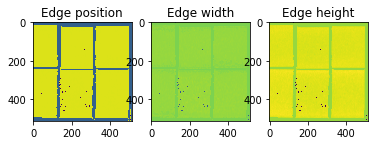

In [10]:
lrange = [3.7, 4.5]
edge_pos = 4.14
est_alpha = 0.001
est_sigma = 0.01
fit_A = edgefitting_2D.AdvancedBraggEdgeFitting_2D(T_mavg, spectrum, lrange, mask = mask,
                                          est_pos = edge_pos, est_alpha = est_alpha, est_sigma = est_sigma, 
                                          bool_smooth = True, smooth_w = 5, smooth_n = 1, 
                                          bool_print = 1)
scipy.io.savemat('fit_A_111.mat',fit_A)

## Printing maps and comparing results
### Edge position

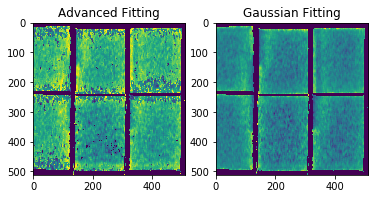

In [43]:
plt.subplot(1,2,1), plt.imshow(fit_A['edge_position'],vmin = 4.13, vmax = 4.15)
plt.title('Advanced Fitting')
plt.subplot(1,2,2), plt.imshow(fit_G['edge_position'],vmin = 4.13, vmax = 4.15)
plt.title('Gaussian Fitting')
plt.show()
plt.close()

### Edge height
For the advanced edge fitting it is calculated as difference before and after.

For the gaussian fitting it is calculated as the amplitude of the derivative gaussian fitting hence, it is actually the slope.

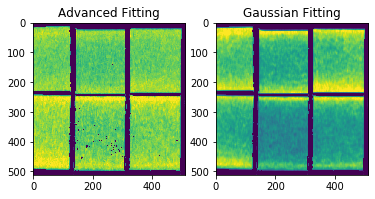

In [51]:
plt.subplot(1,2,1), plt.imshow(fit_A['edge_height'], vmin = 0, vmax = 0.32)
plt.title('Advanced Fitting')
plt.subplot(1,2,2), plt.imshow(fit_G['edge_slope'], vmin = 0, vmax = 0.008)
plt.title('Gaussian Fitting')
plt.show()
plt.close()

### Edge width

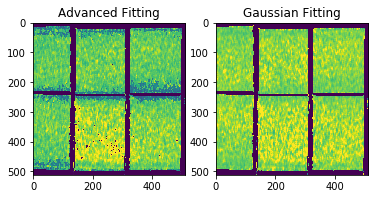

In [52]:
plt.subplot(1,2,1), plt.imshow(fit_A['edge_width'], vmin = 0, vmax = 0.2)
plt.title('Advanced Fitting')
plt.subplot(1,2,2), plt.imshow(fit_G['edge_width'], vmin = 0, vmax = 0.015)
plt.title('Gaussian Fitting')
plt.show()
plt.close()